导入需要的环境

In [2]:

from pathlib import Path
import os
import sys
os.environ['PROJ_LIB'] = '/home/dls/anaconda3/envs/pytorch/share/proj'
# ERROR 1: PROJ: proj_create_from_database: Open of /home/dls/anaconda3/envs/pytorch/share/proj failed 不然会报错
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dggrid4py import DGGRIDv7, Dggs, dgselect, dggs_types


绘制全球图

NameError: name 'sque_Data' is not defined

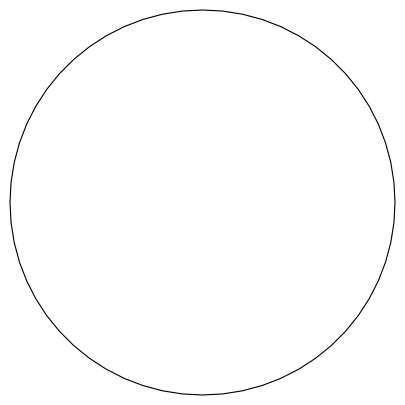

In [2]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=  ccrs.Orthographic(120,20))
# ax.contourf(data['lon'], data['lat'], data.to_numpy(), cmap='RdBu_r', transform=ccrs.Orthographic(),transform_first=True)
sque_Data.TMQ.plot.contourf(ax=ax ,transform =ccrs.PlateCarree())
# 
# ax.coastlines()
ax.set_global()

##计算全球离散格网的经纬度

In [3]:

##测试正则表达式写法 
import re 
def split_map_re(strlist:str):
    strlist = re.sub('[\[\]]','',strlist)
    return strlist
# split_map_re('[ "2", "20480", "36928", "65" ]')
def process_nei_chi(gdf):
    '''由于生成的是字符串数组 需要拆开 处理生成的child和nei s'''

    neighbors_name = ['u','l','d','r']#up left down right
    children_name = ['0','1','2','3']#up left down right
    gd_nei =gdf['neighbors'].str.replace('[\[\]\"]','').str.split(',',expand=True )#如果正则中没有\" 那么生成的数字是 ' "2048" '这种 就是 字符串中包含的字符串 所以需要吧" 也给消除
    gd_nei.rename(columns={x:neighbors_name[x] for x in gd_nei.columns},inplace=True) 
    # print(gd_nei)


    gd_child =gdf['children'].str.replace('[\[\]\"]','').str.split(',',expand=True ) 
    gd_child.rename(columns={x:children_name[x] for x in gd_child.columns},inplace=True) 
    # print(gd_child)
    gdf =gdf.drop(columns={'neighbors','children'}).rename(columns={'name':'seqnum'})
    # gdf.seqnum=gdf.seqnum.astype(int)
    gdf =pd.concat([gdf,gd_nei,gd_child],axis=1)
    
    return gdf.astype(int)
 
def example_read_geojson(dggs_type='ISEA4T',resolution = 6):
    """
    GDALcollection生成输出 包含了边临近编码 子格网编码 自身编码 中心点经纬度 cell边界经纬度
    Args:
        path (_type_):geojson路径
    """    
    dggridPath= '/home/dls/data/openmmlab/DGGRID/build/src/apps/dggrid/dggrid'
    working_dir = '/home/dls/data/openmmlab/python_practice/interpolater/tmp/grids'
    dggrid = DGGRIDv7(executable= dggridPath, working_dir=working_dir, capture_logs=True, silent=False)
    dggs_type='ISEA4D'
    resolution = 6
    gdf_cell_point= dggrid.gen_cell_point( dggs_type=dggs_type,resolution = resolution,if_drop=False)
    # print(gdf_cell_point['seqnum'])
    df_nei_chi= dggrid.gen_nei_chi( dggs_type=dggs_type,resolution = resolution)
    df_nei_chi=process_nei_chi(df_nei_chi)
    # print(df_nei_chi['seqnum'])
    gdf = gdf_cell_point.merge(df_nei_chi,on='seqnum',how ='inner')
    gdf.attrs = {'level':resolution,'dggs_type':dggs_type}
    # gdf_cell = dggrid.gen_cell( dggs_type=dggs_type,resolution = resolution)
    # gdf = gdf_cell_point.join(df_nei_chi,on='seqnum',how ='inner')
    # gdf = gdf_point
    return gdf

gdf = example_read_geojson()

 

** executing DGGRID version 7.5 **
type sizes: big int: 64 bits / big double: 128 bits

** loading meta file metafile_67c031ee-bae4-4d8e-b8cb-3b7f29b6dfc5...
* using parameter values:
dggrid_operation GENERATE_GRID (user set)
dggs_type ISEA4D (user set)
dggs_topology DIAMOND (user set)
dggs_proj ISEA (user set)
dggs_aperture_type PURE (user set)
dggs_aperture 4 (user set)
proj_datum WGS84_AUTHALIC_SPHERE (default)
dggs_orient_specify_type SPECIFIED (user set)
dggs_num_placements 1 (user set)
dggs_orient_output_file_name grid.meta (default)
dggs_vert0_lon 11.25 (user set)
dggs_vert0_lat 58.2825 (user set)
dggs_vert0_azimuth 0 (user set)
dggs_res_specify_type SPECIFIED (user set)
dggs_res_spec 6 (user set)
rng_type RAND (default)
geodetic_densify 0 (default)
clip_subset_type WHOLE_EARTH (user set)
clip_cell_seqnums  (default)
clip_cell_res 1 (default)
clip_cell_densification 1 (default)
clip_region_files test.gen (default)
clip_type POLY_INTERSECT (default)
clipper_scale_factor 1000000 (

/tmp/ipykernel_3913300/181416888.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  gd_nei =gdf['neighbors'].str.replace('[\[\]\"]','').str.split(',',expand=True )#如果正则中没有\" 那么生成的数字是 ' "2048" '这种 就是 字符串中包含的字符串 所以需要吧" 也给消除
/tmp/ipykernel_3913300/181416888.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  gd_child =gdf['children'].str.replace('[\[\]\"]','').str.split(',',expand=True )


In [4]:
# 查看元数据
gdf.attrs

{'level': 6, 'dggs_type': 'ISEA4D'}

In [5]:
#把四邻今转化为八邻近 遵循的规则是?先搞简单的 :l 的 u d =>lu ld  r 的 u p => ru rd
def cal_angle_nei(gdf):
    neighbors_name = ['u','lu','l','ld','d','rd','r','ru']#up left down right
    children_name = ['0','1','2','3']#up left down right
    # 根据边临近计算角临近
    lftList=(gdf.l-1).tolist()
    rigList=(gdf.r-1).tolist()

    gdf['lu'] = gdf.u[lftList].reset_index(drop=True)  #对应的行索引不减1代表的是seqnum lu
    gdf['ld'] = gdf.d[lftList].reset_index(drop=True) #对应的行索引不减1代表的是seqnum lu
    gdf['ru'] = gdf.u[rigList].reset_index(drop=True) #对应的行索引不减1代表的是seqnum lu
    gdf['rd'] = gdf.d[rigList].reset_index(drop=True) #对应的行索引不减1代表的是seqnum lu
    # col=list(gdf.columns)
    # col.reverse()
    gdf=gdf[['seqnum']+neighbors_name+children_name+['cell','point']]
    return gdf

In [6]:
gdf = cal_angle_nei(gdf)
# lftList=(gdf.l-1).tolist()
 
# gdf['lu'] = gdf.u[lftList].reset_index(drop=True) #对应的行索引不减1代表的是seqnum lu
gdf.head()


,seqnum,u,lu,l,ld,d,rd,r,ru,0,1,2,3,cell,point
0,1,2,1,20480,20479,36928,36992,65,66,1,2,129,130,"POLYGON ((-168.75000 58.28253, -167.71565 57.5...",POINT (-167.89257 58.42554)
1,2,3,2,20416,20415,1,65,66,67,3,4,131,132,"POLYGON ((-168.75000 59.22767, -167.02635 58.5...",POINT (-167.70213 59.48407)
2,3,4,3,20352,20351,2,66,67,68,5,6,133,134,"POLYGON ((-168.75000 60.17697, -166.63662 59.7...",POINT (-167.67652 60.43064)
3,4,5,4,20288,20287,3,67,68,69,7,8,135,136,"POLYGON ((-168.75000 61.13033, -166.58477 60.6...",POINT (-167.64876 61.38150)
4,5,6,5,20224,20223,4,68,69,70,9,10,137,138,"POLYGON ((-168.75000 62.08763, -166.52853 61.6...",POINT (-167.61862 62.33652)


In [123]:
##保存数据
compression ='bz2' #这个压缩率和读取率 keep blance https://zhuanlan.zhihu.com/p/115642111
savpath='dggsType_{}_level_{}_com_{}.pkl'.format(gdf.attrs['dggs_type'],gdf.attrs['level'],compression)
gdf.to_pickle(savpath,compression)

In [124]:
##读取数据
pd.read_pickle(savpath,compression=compression)

,seqnum,point,cell,u,l,d,r,0,1,2,3
0,1,POINT (-167.89257 58.42554),"POLYGON ((-168.75000 58.28253, -167.71565 57.5...",2,20480,36928,65,1,2,129,130
1,2,POINT (-167.70213 59.48407),"POLYGON ((-168.75000 59.22767, -167.02635 58.5...",3,20416,1,66,3,4,131,132
2,3,POINT (-167.67652 60.43064),"POLYGON ((-168.75000 60.17697, -166.63662 59.7...",4,20352,2,67,5,6,133,134
3,4,POINT (-167.64876 61.38150),"POLYGON ((-168.75000 61.13033, -166.58477 60.6...",5,20288,3,68,7,8,135,136
4,5,POINT (-167.61862 62.33652),"POLYGON ((-168.75000 62.08763, -166.52853 61.6...",6,20224,4,69,9,10,137,138
...,...,...,...,...,...,...,...,...,...,...,...
40955,40956,POINT (-138.78906 -3.69681),"POLYGON ((-139.36875 -3.77410, -138.50846 -4.5...",40957,40892,40955,20737,163703,163704,163831,163832
40956,40957,POINT (-138.49454 -2.78807),"POLYGON ((-139.07654 -2.86705, -138.20993 -3.6...",40958,40893,40956,20673,163705,163706,163833,163834
40957,40958,POINT (-138.20197 -1.88317),"POLYGON ((-138.78659 -1.96400, -137.91320 -2.7...",40959,40894,40957,20609,163707,163708,163835,163836
40958,40959,POINT (-137.91125 -0.98222),"POLYGON ((-138.49879 -1.06506, -137.61814 -1.8...",40960,40895,40958,20545,163709,163710,163837,163838


In [3]:
#加载数据
import xarray as xr
ncvar = '/home/dls/data/climatenet/train/data-1996-09-26-01-1_1.nc'
ncvar = '/home/dls/data/climatenet/train/data-1996-09-26-01-1_1.nc'

data=xr.load_dataset(ncvar).squeeze(dim='time',drop=True)
labels= data.LABELS 

data=data.drop_vars('LABELS')
for var in data:
    print(data[var])
    break
 

<xarray.DataArray 'TMQ' (lat: 768, lon: 1152)>
array([[0.53076255, 0.53076255, 0.53076255, ..., 0.53076255, 0.53076255,
        0.53076255],
       [0.5495671 , 0.5492891 , 0.5490986 , ..., 0.5512765 , 0.55065316,
        0.55000937],
       [0.55502826, 0.55466026, 0.5543167 , ..., 0.55630785, 0.55590564,
        0.5554463 ],
       ...,
       [7.4789753 , 7.468994  , 7.4715047 , ..., 7.4755735 , 7.4755507 ,
        7.477523  ],
       [7.043618  , 7.042363  , 7.041062  , ..., 7.0504785 , 7.0490065 ,
        7.044829  ],
       [6.1110277 , 6.1110277 , 6.1110277 , ..., 6.1110277 , 6.1110277 ,
        6.1110277 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    description:  total (vertically integrated) precipitable water
    units:         kg/m^2


In [17]:
#插值
lat = gdf.point.y
lon = gdf.point.x
interdata = data.interp(lat=lat,lon=lon,method='linear' )
interlabel = labels.interp(lat=lat,lon=lon,method='nearest')


: 

: 

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
airtemps = xr.tutorial.open_dataset("rasm")
airtemps

<xarray.Dataset>
Dimensions:  (time: 36, y: 205, x: 275)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 ...
    yc       (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    Tair     (time, y, x) float64 ...
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

In [ ]:
print(airtemps.xc.to_numpy())
print(airtemps.yc.attrs)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
airtemps.xc.plot(ax=ax1)
airtemps.yc.plot(ax=ax2)

In [ ]:
plt.scatter(airtemps["xc"], airtemps["yc"])  # plot grid locations
# plt.ylim([-90, 90])
plt.xlabel("lon")
plt.ylabel("lat")

In [1]:
import shutil
shutil.rmtree('./tmp')